In [1]:
from zipfile import ZipFile
from pathlib import Path
import msgpack

In [4]:
ID = "2021-04-16"
N = 90
# NUM_ANS = 140 * N
NUM_ANS = 90 * N
# NUM_ANS = 7200
# NUM_ANS = 6300
# NUM_ANS = 9000
# 630: SOE is the worst. TSTE and CKL even.
# 480: TSTE > CKL > SOE
# 780: CKL ~= TSTE > SOE
NUM_ANS

8100

In [5]:
from collections import defaultdict

data = []
counter = 0
N_ANS = set()

for fname in ["embeddings.zip", "n=30.zip"]:
    with ZipFile(f"io/{ID}/{fname}") as zf:
        print(f"{len(zf.filelist)} embeddings")
        for f in zf.filelist:
            assert ".msgpack" in f.filename
            ir = zf.read(f)
            raw = msgpack.loads(ir)
            assert set(raw.keys()) == {"embedding", "history", "perf", "params", "meta"}
            n = raw["params"]["n"]
            if n == N:
                N_ANS.update({raw["meta"]["num_ans"]})
            if n == N and raw["meta"]["num_ans"] == NUM_ANS:
                hist = raw["history"]
                lens = {len(v) for v in hist.values()}
                assert len(lens) == 1
                key = list(hist.keys())[0]
                hist = [
                    {k: hist[k][i] for k in hist}
                    for i in range(len(hist[key]))
                ]
                for h in hist:
                    h["sampling"] = raw["meta"]["sampling"]
                    h["noise_model"] = raw["params"]["noise_model"]
                data.extend(hist)
                counter += 1
print(f"{counter} histories collected after filtering for N={N} and NUM_ANS={NUM_ANS}, ")
print(f"N_ANS=")
list(sorted(list(N_ANS)))


87 embeddings
254 embeddings
1 histories collected after filtering for N=90 and NUM_ANS=8100, 
N_ANS=


[90,
 540,
 990,
 1440,
 1890,
 2340,
 2790,
 3240,
 3690,
 4140,
 4500,
 5400,
 7200,
 8100,
 9000,
 10800]

In [6]:
import pandas as pd
df = pd.DataFrame(data)
df["epochs/1e6"] = df["_epochs"] / 1e6

In [7]:
df.head()

,pf_calls,num_answers,model_updates,num_grad_comps,answers_bytes,score_train,loss_train,k,elapsed_time,train_data,...,verbose,ident,_epochs,last_score,score_test,loss_test,_elapsed_time,sampling,noise_model,epochs/1e6
0,1,8100,16,8192,60600,0.506667,0.693146,0,0.053015,8100,...,1000,CKL-active,1.011358,0.506667,0.49870,0.693146,0.077363,active,CKL,0.000001
1,1001,8100,16016,8204680,60600,0.709259,0.596068,1000,0.087168,8100,...,1000,CKL-active,1012.923457,0.709259,0.60725,0.660855,39.547444,active,CKL,0.001013
2,2001,8100,32016,16410672,60600,0.751111,0.555583,2000,0.122164,8100,...,1000,CKL-active,2026.008889,0.751111,0.65040,0.638043,77.239505,active,CKL,0.002026
3,3001,8100,48016,24626115,60600,0.767531,0.533476,3000,0.164428,8100,...,1000,CKL-active,3040.261111,0.767531,0.67385,0.613454,114.990515,active,CKL,0.003040
4,4001,8100,64016,32851026,60600,0.779259,0.517171,4000,0.207060,8100,...,1000,CKL-active,4055.682222,0.779259,0.68650,0.589521,153.186407,active,CKL,0.004056


In [8]:
df.columns

Index(['pf_calls', 'num_answers', 'model_updates', 'num_grad_comps',
       'answers_bytes', 'score_train', 'loss_train', 'k', 'elapsed_time',
       'train_data', 'n', 'd', 'max_epochs', 'verbose', 'ident', '_epochs',
       'last_score', 'score_test', 'loss_test', '_elapsed_time', 'sampling',
       'noise_model', 'epochs/1e6'],
      dtype='object')

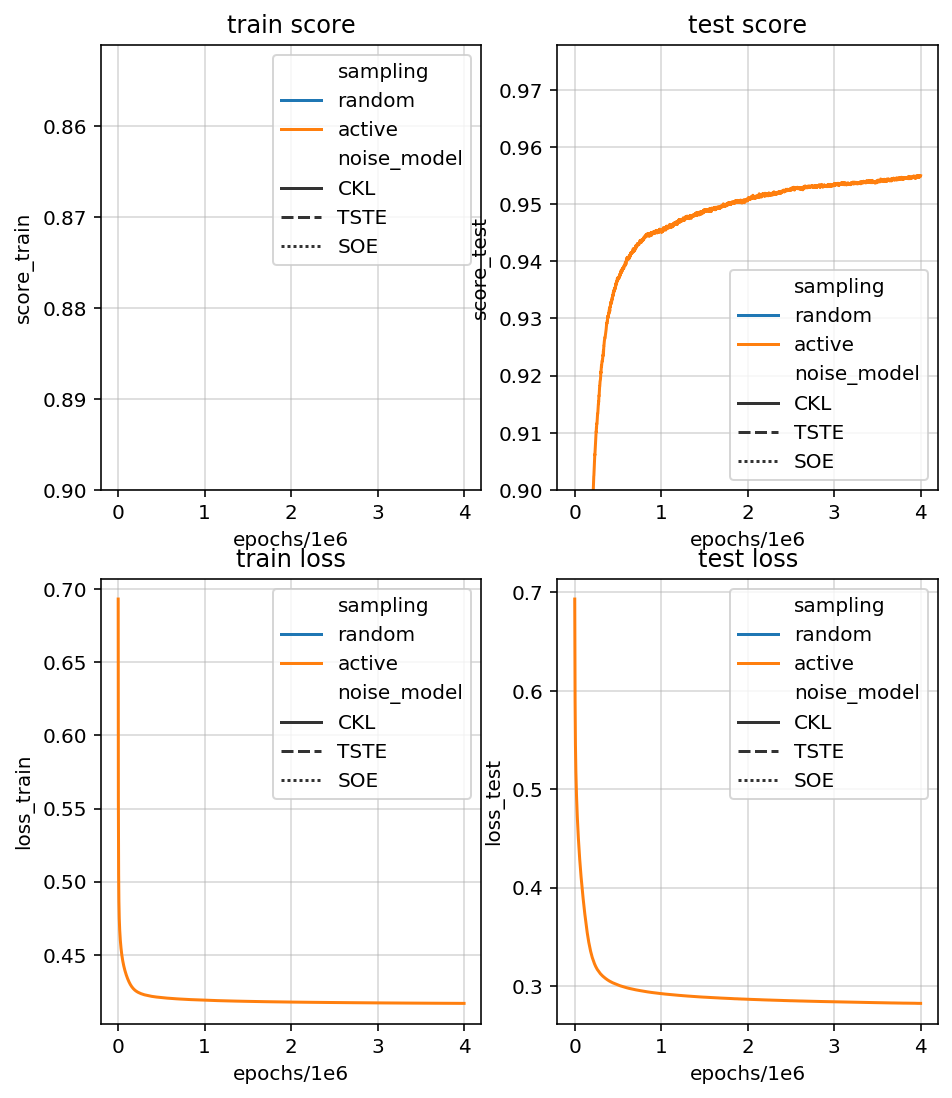

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

w = 3
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(2.5 * w, 3.0 * w))
counter = 0
for measure in ["score", "loss"]:
    for dset in ["train", "test"]:
        ax = sns.lineplot(
            x="epochs/1e6",
            y=f"{measure}_{dset}",
            hue="sampling",
            hue_order=["random", "active"],
            style="noise_model",
            style_order=["CKL", "TSTE", "SOE"],
            data=df,#[df.sampling == "random"],
#             ci=None,
            ci="sd",
            ax=axs.flatten()[counter],
        )
        if measure == "score":
            _ = ax.set_ylim(0.90, None)
#             ax.set_xlim(0, 1)
        ax.grid(alpha=0.5)
        _ = ax.set_title(f"{dset} {measure}");
        
        counter += 1

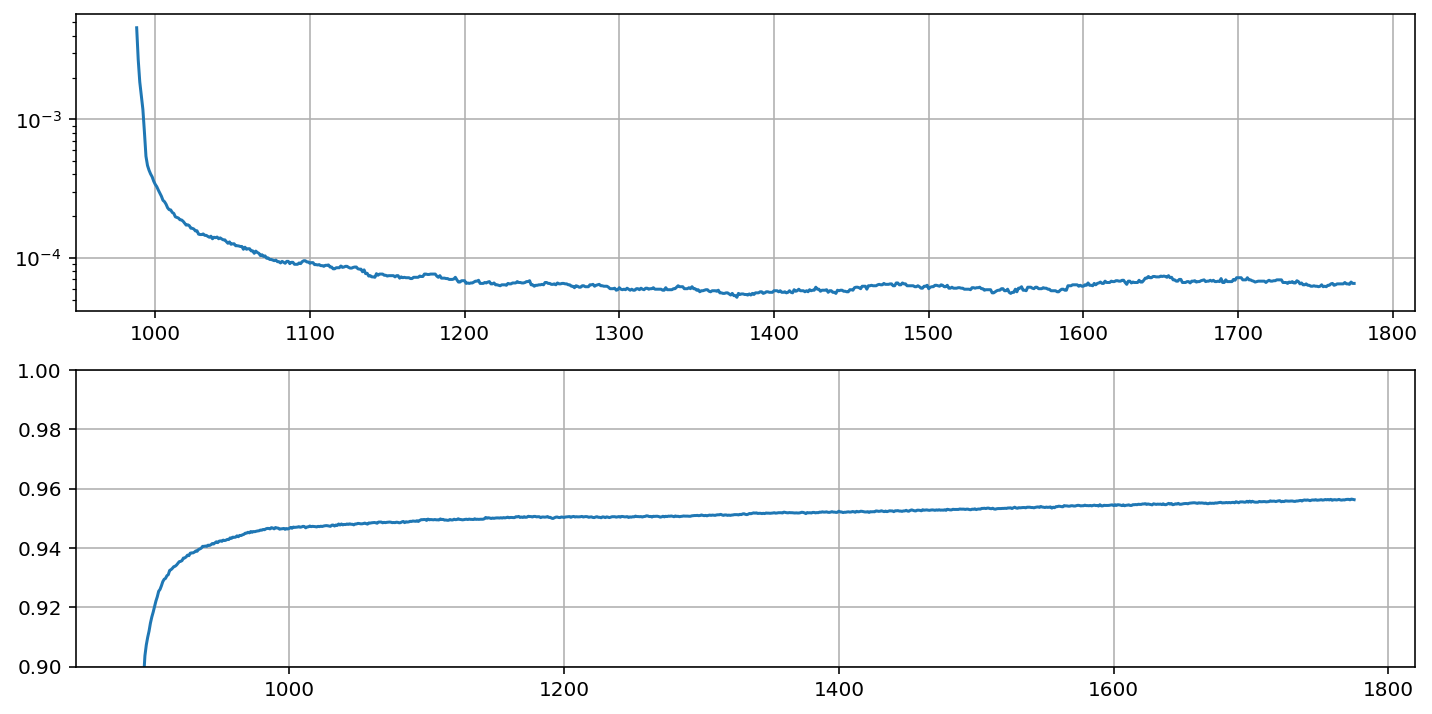

In [521]:
import numpy as np
show = df[(df.noise_model == "CKL") & (df.sampling == "active")]
s = show.sort_values(by="_epochs")
s["_diff"] = np.maximum(0, s["score_test"].diff())

w = 3
fig, axs = plt.subplots(nrows=2, figsize=(4 * w, 2 * w))
ax = s.loc[s._epochs >= 1000, "_diff"].rolling(window=100).mean().plot(ax=axs[0])
ax.set_yscale("log")
ax.grid()
ax = s.loc[s._epochs >= 1000, "score_test"].plot(ax=axs[1])
ax.set_ylim(0.9, 1)
ax.grid()

In [494]:
show

,pf_calls,num_answers,model_updates,num_grad_comps,answers_bytes,score_train,loss_train,k,elapsed_time,train_data,...,verbose,ident,_epochs,last_score,score_test,loss_test,_elapsed_time,sampling,noise_model,epochs/1e6
0,1,7200,15,7680,55200,0.504444,0.693146,0,0.052930,7200,...,1000,CKL-active,1.066667,0.504444,0.49840,0.693146,0.090433,active,CKL,0.000001
1,1001,7200,15015,7691616,55200,0.710972,0.595444,1000,0.093100,7200,...,1000,CKL-active,1068.280000,0.710972,0.60095,0.670515,47.023098,active,CKL,0.001068
2,2001,7200,30001,15376715,55200,0.755972,0.552431,2000,0.138126,7200,...,1000,CKL-active,2135.654861,0.755972,0.63125,0.659211,95.203667,active,CKL,0.002136
3,3001,7200,45001,23077312,55200,0.766389,0.529860,3000,0.183614,7200,...,1000,CKL-active,3205.182222,0.766389,0.64910,0.638782,143.600181,active,CKL,0.003205
4,4001,7200,60001,30786248,55200,0.773472,0.515527,4000,0.220689,7200,...,1000,CKL-active,4275.867778,0.773472,0.66325,0.615887,191.578113,active,CKL,0.004276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,709001,7200,10635001,7144982720,55200,0.834028,0.415824,709000,25.867046,7200,...,1000,CKL-active,992358.711111,0.834028,0.94925,0.289642,24423.551055,active,CKL,0.992359
710,710001,7200,10650001,7156006720,55200,0.834444,0.415821,710000,25.903147,7200,...,1000,CKL-active,993889.822222,0.834444,0.94910,0.289627,24460.082019,active,CKL,0.993890
711,711001,7200,10665001,7167030720,55200,0.833889,0.415820,711000,25.936473,7200,...,1000,CKL-active,995420.933333,0.833889,0.94925,0.289621,24495.078326,active,CKL,0.995421
712,712001,7200,10680001,7178054720,55200,0.834306,0.415814,712000,25.970809,7200,...,1000,CKL-active,996952.044444,0.834306,0.94915,0.289608,24530.072901,active,CKL,0.996952
